# IEOR 4571 - Personalization - Final Project

#### Team members: 
Name, UNI/email, Github ID
* Megala Kannan, msk2245@columbia.edu, thisismeg
* Hojin Lee, hl3328@columbia.edu, hjlee9295
* Jung Ah Shin, js5569@columbia.edu, juliajungahshin
* Tiffany Zhu, tz2196@columbia.edu, tlzhu19


# TOC:
* [1. Introduction](#1)
* [2. Data Exploration](#2)
* [3. Modeling](#3)
    * [3.1 Baseline Models](#3-1)
        * [3.1.1 Learned Bias Baseline Model](#3-1-1)
        * [3.1.2 Collaborative Filtering Baseline Model](#3-1-2)
    * [3.2 Collective Matrix Factorization](#3-2)
* [4. Evaluation](#4)
    * [4.1 Accuracy](#4-1)
    * [4.2 Coverage](#4-2)
* [5. Conclusion](#5)


# 1. Introduction <a class="anchor" id="1"></a>

# 2. Data Exploration <a class="anchor" id="2"></a>

In [110]:
import pandas as pd
import json
from tqdm import tqdm

import numpy as np # linear algebra
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

import itertools
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [111]:
def convert_json_to_df(path, file_name, column_names):
    '''
    converts the json file into a pandas dataframe
    path: string of path
    file_name: string of json file name
    column_names: the names of the json file attributes (used as the dataframe column names)
    returns: dataframe
    '''
    line_count = len(open(path + file_name).readlines())    
    columns_dict = {name: [] for name in column_names}

    with open(path + file_name) as f:
        for line in tqdm(f, total=line_count):
            blob = json.loads(line)
            
            for key in column_names:
                columns_dict[key].append(blob[key])
    
    return pd.DataFrame(columns_dict)

In [112]:
path = "/Users/tiffanyzhu/Downloads/yelp_dataset/"
file_name = "review.json"

In [4]:
# review.json
ratings = convert_json_to_df(path, file_name, ['user_id', 'business_id', 'stars', 'date'])

user_counts = ratings["user_id"].value_counts()
active_users = user_counts.loc[user_counts >= 5].index.tolist()

100%|██████████| 6685900/6685900 [01:21<00:00, 82502.81it/s]


In [5]:
len(active_users)

286130

In [6]:
ratings.rename(columns={'stars': 'rating'}, inplace=True)
ratings.head()

,user_id,business_id,rating,date
0,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.0,2013-05-07 04:34:36
1,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5.0,2017-01-14 21:30:33
2,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5.0,2016-11-09 20:09:03
3,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5.0,2018-01-09 20:56:38
4,ssoyf2_x0EQMed6fgHeMyQ,b1b1eb3uo-w561D0ZfCEiQ,1.0,2018-01-30 23:07:38


In [6]:
# can do the same for business.json, user.json, tip.json 
# for metadata info see https://www.yelp.com/dataset/documentation/main

In [99]:
# business.json
# todo: how to add 'attributes'?
'''
"attributes": {
        "RestaurantsTakeOut": true,
        "BusinessParking": {
            "garage": false,
            "street": true,
            "validated": false,
            "lot": false,
            "valet": false
        },
'''

businesses = convert_json_to_df(path, 'business.json', ['business_id', 'city', 'state', 'stars', 
                                                        'review_count', 'is_open', 'attributes', 
                                                        'categories', 'hours', 'latitude', 'longitude', 'name'])

100%|██████████| 192609/192609 [00:04<00:00, 41327.48it/s]


In [100]:
businesses.head()

,business_id,city,state,stars,review_count,is_open,attributes,categories,hours,latitude,longitude,name
0,1SWheh84yJXfytovILXOAQ,Phoenix,AZ,3.0,5,0,{'GoodForKids': 'False'},"Golf, Active Life",None,33.522143,-112.018481,Arizona Biltmore Golf Club
1,QXAEGFB4oINsVuTFxEYKFQ,Mississauga,ON,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",43.605499,-79.652289,Emerald Chinese Restaurant
2,gnKjwL_1w79qoiV3IC_xQQ,Charlotte,NC,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...","Sushi Bars, Restaurants, Japanese","{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",35.092564,-80.859132,Musashi Japanese Restaurant
3,xvX2CttrVhyG2z1dFg_0xw,Goodyear,AZ,5.0,3,1,None,"Insurance, Financial Services","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",33.455613,-112.395596,Farmers Insurance - Paul Lorenz
4,HhyxOkGAM07SRYtlQ4wMFQ,Charlotte,NC,4.0,4,1,"{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...","Plumbing, Shopping, Local Services, Home Servi...","{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",35.190012,-80.887223,Queen City Plumbing


In [13]:
# user.json
users = convert_json_to_df(path, 'user.json', ['user_id', 'review_count', 'friends', 'useful', 
                                               'funny', 'cool', 'fans', 'elite', 'average_stars', 
                                               'compliment_hot', 'compliment_more', 'compliment_profile',
                                               'compliment_cute', 'compliment_list', 'compliment_note',
                                               'compliment_plain', 'compliment_cool', 'compliment_funny',
                                               'compliment_writer', 'compliment_photos'
                                              ])

100%|██████████| 1637138/1637138 [00:35<00:00, 46222.22it/s]


In [20]:
users.head()

,user_id,review_count,friends,useful,funny,cool,fans,elite,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,l6BmjZMeQD3rDxWUbiAiow,95,"c78V-rj8NQcQjOI8KP3UEA, alRMgPcngYSCJ5naFRBz5g...",84,17,25,5,"2015,2016,2017",4.03,2,0,0,0,0,1,1,1,1,2,0
1,4XChL029mKr5hydo79Ljxg,33,"kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGTPg...",48,22,16,4,,3.63,1,0,0,0,0,0,0,1,1,0,0
2,bc8C_eETBWL0olvFSJJd0w,16,"4N-HU_T32hLENLntsNKNBg, pSY2vwWLgWfGVAAiKQzMng...",28,8,10,0,,3.71,0,0,0,0,0,1,0,0,0,0,0
3,dD0gZpBctWGdWo9WlGuhlA,17,"RZ6wS38wnlXyj-OOdTzBxA, l5jxZh1KsgI8rMunm-GN6A...",30,4,14,5,,4.85,1,0,0,0,0,0,2,0,0,1,0
4,MM4RJAeH6yuaN8oZDSt0RA,361,"mbwrZ-RS76V1HoJ0bF_Geg, g64lOV39xSLRZO0aQQ6DeQ...",1114,279,665,39,"2015,2016,2017,2018",4.08,28,1,0,0,1,16,57,80,80,25,5


In [14]:
# tip.json
tips =  convert_json_to_df(path, 'tip.json', ['text', 'date', 'compliment_count', 'business_id', 'user_id'])

100%|██████████| 1223094/1223094 [00:09<00:00, 122404.61it/s]


In [29]:
photos = convert_json_to_df(path, 'photo.json', ['photo_id', 'business_id'])

100%|██████████| 200000/200000 [00:01<00:00, 194952.47it/s]


[Text(0.5, 0, 'Rating'), Text(0.5, 1.0, 'Distribution of Ratings')]

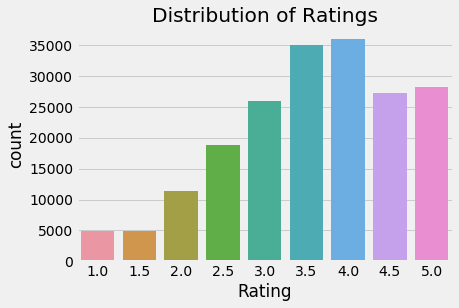

In [80]:
chart = sns.countplot(x='stars',data=businesses)
chart.set(xlabel='Rating', title='Distribution of Ratings')

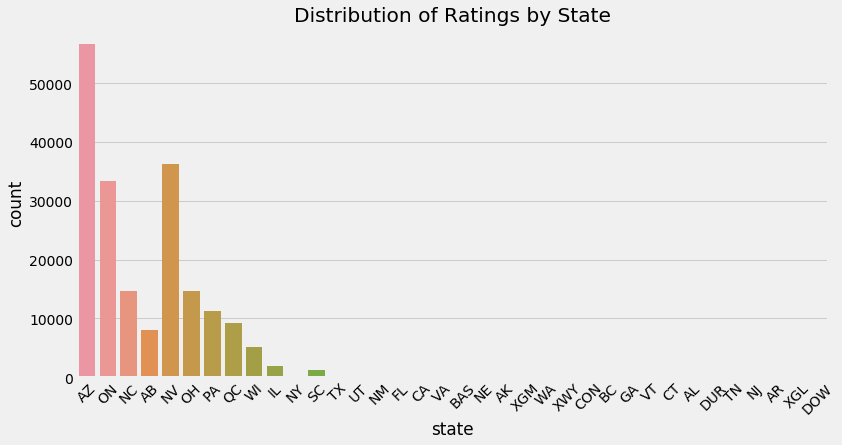

In [93]:
# uneven distribution of data among states -> cannot apply Location Aware Recommender System.
plt.figure(figsize=(12,6))
chart = sns.countplot(x='state',data=businesses)
chart2 = chart.set(title='Distribution of Ratings by State')
chart3 = chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

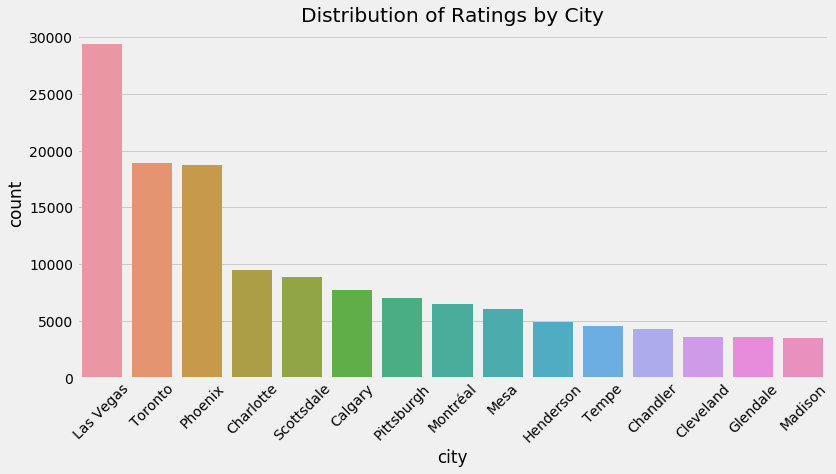

In [103]:
plt.figure(figsize=(12,6))
chart = sns.countplot(x='city',data=businesses, order=pd.value_counts(businesses['city']).iloc[:15].index)
chart.set(title='Distribution of Ratings by City')
foo = chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

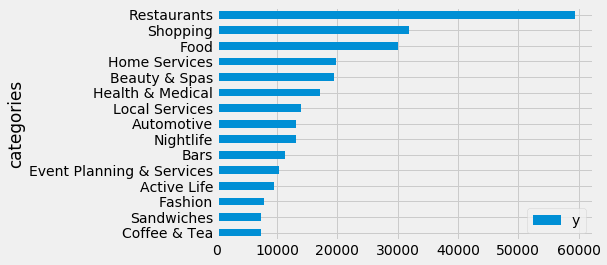

In [97]:
catList = []
businesses['categories'].fillna(value='',inplace=True)
businesses['cat'] = businesses['categories'].apply(lambda x: x.split(','))
catList.extend(businesses['cat'])
merged = [x.strip() for x in list(itertools.chain(*catList))]

mostCommon = Counter(merged).most_common(15)
mostCommonKeys = [x for x in list(itertools.chain(*mostCommon)) if type(x) != int]
mostCommonValues = [x for x in list(itertools.chain(*mostCommon)) if type(x) == int]

df = pd.DataFrame({'y': mostCommonValues, 'categories': mostCommonKeys})
ax = df.plot.barh(x='categories', y='y')
ax.invert_yaxis()

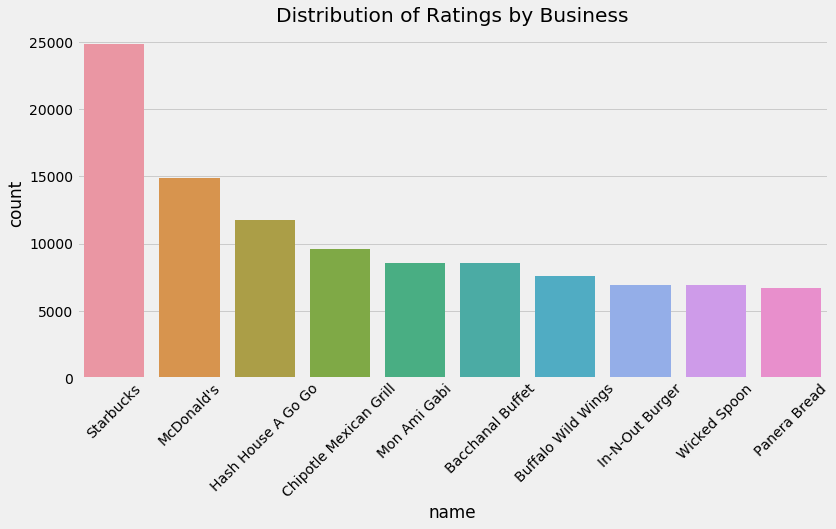

In [104]:
df = ratings.merge(businesses[['business_id', 'name']], on='business_id')
plt.figure(figsize=(12,6))

chart = sns.countplot(x='name',data=df, order=pd.value_counts(df['name']).iloc[:10].index)
chart.set(title='Distribution of Ratings by Business')
var = chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

# 3. Modeling <a class="anchor" id="3"></a>

## 3.0 Sampling Data

In [185]:
active_user_only_ratings_df = ratings[ratings['user_id'].isin(active_users)]
len(active_user_only_ratings_df)

4538272

In [186]:
len(active_user_only_ratings_df['user_id'].unique())

286130

In [122]:
sample_size = [100]

for s in sample_size:
    sampleUID = active_user_only_ratings_df['user_id'].unique()[np.random.randint(active_user_only_ratings_df['user_id'].unique().shape[0], size=s)]
    active_user_only_ratings_df_sample = active_user_only_ratings_df[active_user_only_ratings_df['user_id'].isin(sampleUID)]

In [123]:
import datetime as dt
active_user_only_ratings_df_sample['date'] = pd.to_datetime(active_user_only_ratings_df_sample['date'])

# take 80% of reviews for each user sampled
training_data = active_user_only_ratings_df_sample.sort_values(by=['user_id', 'date']).groupby('user_id').apply(lambda x: x[:round(len(x)*.8)]).reset_index(drop=True)

# take 20% of reviews for each user sampled
testing_data = active_user_only_ratings_df_sample.sort_values(by=['user_id', 'date']).groupby('user_id').apply(lambda x: x[round(len(x)*.8):]).reset_index(drop=True)

## 3.1 Baseline Model <a class="anchor" id="3-1"></a>

### 3.1.1 Learned Bias Baseline Model <a class="anchor" id="3-1-1"></a>

In [150]:
X_data = active_user_only_ratings_df_sample.sort_values(by=['user_id', 'date']).groupby('user_id').apply(lambda x: x[:-1]).reset_index(drop=True)
y_data = active_user_only_ratings_df_sample.sort_values(by=['user_id', 'date']).groupby('user_id').apply(lambda x: x[-1:]).reset_index(drop=True)

In [152]:
y_data.head()

,user_id,business_id,rating,date
0,-3rnhAew4Fl0kj55auAXsw,ZgxDI80zPcKTQpoDjnQmUw,5.0,2018-08-27 10:23:46
1,-aAgfEUH4UoFDRXZCfJSUA,F1CCt2Gl6qpOB73mXi5anA,4.0,2018-08-17 13:29:14
2,-uQ-YdXqbTZtBwU0bMfugg,MlUS2LiVNaJBLdK5U565Kw,1.0,2016-08-25 06:49:07
3,03nkVeDCMtei1Xjk6ZVjQA,w8pbtr9dLq7RENGYXvldMA,4.0,2015-03-26 00:10:57
4,0CrxSrRjR4QLsH8cclii-Q,aUoyVTG3TpGaALoMqua49g,5.0,2017-04-20 17:59:10


In [153]:
def find_average_user_ratings(ratings_df):
    ratings_series = ratings_df.groupby('user_id')['rating'].mean()
    return pd.DataFrame({'user_id':ratings_series.index, 'rating':ratings_series.values})

average_user_ratings = find_average_user_ratings(X_data)

In [154]:
def find_average_business_ratings(ratings_df):    
    ratings_series = ratings_df.groupby('business_id')['rating'].mean()
    return pd.DataFrame({'business_id':ratings_series.index, 'rating':ratings_series.values})

average_business_ratings = find_average_business_ratings(X_data)

In [155]:
# average_user_ratings.get(average_user_ratings.index[0])
average_user_ratings.head()

,user_id,rating
0,-3rnhAew4Fl0kj55auAXsw,2.333333
1,-aAgfEUH4UoFDRXZCfJSUA,4.000000
2,-uQ-YdXqbTZtBwU0bMfugg,2.909091
3,03nkVeDCMtei1Xjk6ZVjQA,4.714286
4,0CrxSrRjR4QLsH8cclii-Q,4.000000


In [156]:
average_business_ratings.head()

,business_id,rating
0,--FBCX-N37CMYDfs790Bnw,5.0
1,-4cA4Kt0UKzGYimrZsYuQg,3.0
2,-4z8BUBG6DSLVpbFAs8HMg,5.0
3,-7H-oXvCxJzuT42ky6Db0g,3.0
4,-8ZiMXZReeTD3kwEvS0Lww,4.0


In [157]:
X_data.head()

,user_id,business_id,rating,date
0,-3rnhAew4Fl0kj55auAXsw,HKA-V3sxBDUyURIEDjArow,1.0,2016-05-13 15:06:48
1,-3rnhAew4Fl0kj55auAXsw,CUgRXXf5UQVqj0DudnrT5A,5.0,2016-05-15 21:28:38
2,-3rnhAew4Fl0kj55auAXsw,G60mnTWpe1J13fWhIGlmxA,1.0,2016-05-30 20:00:49
3,-3rnhAew4Fl0kj55auAXsw,J-FuCgC_2TVC3cMBec0w8A,1.0,2016-09-03 20:54:22
4,-3rnhAew4Fl0kj55auAXsw,HwEDsb1xtRBTuFwATTRjpA,1.0,2018-08-27 09:41:05


In [158]:
y_data.head()

,user_id,business_id,rating,date
0,-3rnhAew4Fl0kj55auAXsw,ZgxDI80zPcKTQpoDjnQmUw,5.0,2018-08-27 10:23:46
1,-aAgfEUH4UoFDRXZCfJSUA,F1CCt2Gl6qpOB73mXi5anA,4.0,2018-08-17 13:29:14
2,-uQ-YdXqbTZtBwU0bMfugg,MlUS2LiVNaJBLdK5U565Kw,1.0,2016-08-25 06:49:07
3,03nkVeDCMtei1Xjk6ZVjQA,w8pbtr9dLq7RENGYXvldMA,4.0,2015-03-26 00:10:57
4,0CrxSrRjR4QLsH8cclii-Q,aUoyVTG3TpGaALoMqua49g,5.0,2017-04-20 17:59:10


In [174]:
# ratings_df - for each user need to remove its last review

def predict_learned_bias(actual_ratings, average_user_ratings, average_business_ratings):

    avg_business_ratings_dict = dict(zip(average_business_ratings.business_id, average_business_ratings.rating))
    
    def find_business_avg(row):
        #todo: what if business we are trying to predict was not seen? give it 3 (out of 5)?
        return avg_business_ratings_dict.get(row['business_id'], 4)  
    
    avg_business_ratings = actual_ratings.apply(find_business_avg, axis=1)
    print('avg_business_ratings created!')
    
    # we are assuming that the order is the same in each avg_business_ratings and average_user_ratings
    predicted_rating = (avg_business_ratings + average_user_ratings['rating']) / 2
    print('predicted_rating created!')
    
    actual_ratings['predicted_rating'] = predicted_rating.values
    
    return actual_ratings
    
baseline_line_predictions_test = predict_learned_bias(y_data, average_user_ratings, average_business_ratings)
baseline_line_predictions_train = predict_learned_bias(X_data, average_user_ratings, average_business_ratings)

avg_business_ratings created!
predicted_rating created!
avg_business_ratings created!
predicted_rating created!


In [178]:
N = len(baseline_line_predictions_test)
baseline_rmse_test = np.sum(np.sqrt(((baseline_line_predictions_test['predicted_rating'] - baseline_line_predictions_test['rating']) / N) ** 2))

In [179]:
baseline_rmse_test

1.1530508932251118

In [177]:
baseline_line_predictions

,user_id,business_id,rating,date,predicted_rating
0,-3rnhAew4Fl0kj55auAXsw,ZgxDI80zPcKTQpoDjnQmUw,5.0,2018-08-27 10:23:46,3.166667
1,-aAgfEUH4UoFDRXZCfJSUA,F1CCt2Gl6qpOB73mXi5anA,4.0,2018-08-17 13:29:14,4.000000
2,-uQ-YdXqbTZtBwU0bMfugg,MlUS2LiVNaJBLdK5U565Kw,1.0,2016-08-25 06:49:07,3.454545
3,03nkVeDCMtei1Xjk6ZVjQA,w8pbtr9dLq7RENGYXvldMA,4.0,2015-03-26 00:10:57,4.357143
4,0CrxSrRjR4QLsH8cclii-Q,aUoyVTG3TpGaALoMqua49g,5.0,2017-04-20 17:59:10,4.000000
...,...,...,...,...,...
95,xNB5zwwbsYuXjHQrz0EV5Q,c7YiIuaacsy1H6D3ZwPX4g,5.0,2018-10-30 19:41:43,4.500000
96,xPyx3Yx3bTExFaJMxv1Uqg,7WMZw8aY2h1Caa67y1LjuA,5.0,2018-01-18 01:02:25,4.500000
97,xf8w-cxFN_vOjm9T1A7P_Q,cgDRx5Nf-NRPx3Infjgt0w,5.0,2018-06-26 23:21:04,3.937500
98,zEkbHlWvDM_oLQ-2DDHwaA,-Eu04UHRqmGGyvYRDY8-tg,4.0,2016-08-16 15:12:45,4.083333


In [139]:
def calculate_catalog_coverage(ratingsDict, N, k=3, pred_col_name='predicted_rating'):
    '''
    k: top k businesses
    N: total number of businesses
    '''
    
    recList = []
    for keys in ratingsDict.keys():
        
        if k >= len(ratingsDict[keys]):
            for row in ratingsDict[keys]:
                recList.append(row['business_id'])
        else:
            for index, item in enumerate(sorted(ratingsDict[keys], key=lambda x: -x[pred_col_name])):
                if index+1 <= k:
                    recList.append(item['business_id'])
                else:
                    pass

    recommended_set = set(recList)

    coverage = (len(recommended_set) / N) * 100
    print('Catalog Coverage: {}%'.format(coverage))
    return coverage

In [184]:
baseline_line_predictions_dict = dict(baseline_line_predictions_train.set_index('user_id').groupby(level = 0).apply(lambda x : x.to_dict(orient= 'records')))
N = len(baseline_line_predictions_train['business_id'].unique())
calculate_catalog_coverage(baseline_line_predictions_dict, N, k=5)

Catalog Coverage: 40.49955396966994%


40.49955396966994

### 3.1.2 Collaborative Filtering Baseline Model <a class="anchor" id="3-1-1"></a>

## 3.2 Collective Matrix Factorization <a class="anchor" id="3-2"></a>

In [55]:
active_user_only_ratings_df = ratings[ratings['user_id'].isin(active_users)]

sample_size = [100]

for s in sample_size:
    sampleUID = active_user_only_ratings_df['user_id'].unique()[np.random.randint(active_user_only_ratings_df['user_id'].unique().shape[0], size=s)]
    active_user_only_ratings_df_sample = active_user_only_ratings_df[active_user_only_ratings_df['user_id'].isin(sampleUID)]



In [56]:
import datetime as dt
active_user_only_ratings_df_sample['date'] = pd.to_datetime(active_user_only_ratings_df_sample['date'])

In [66]:
len(active_user_only_ratings_df_sample)

1343

In [68]:
import datetime as dt
active_user_only_ratings_df_sample['date'] = pd.to_datetime(active_user_only_ratings_df_sample['date'])

# take 80% of reviews for each user sampled
training_data = active_user_only_ratings_df_sample.sort_values(by=['user_id', 'date']).groupby('user_id').apply(lambda x: x[:round(len(x)*.8)]).reset_index(drop=True)

# take 20% of reviews for each user sampled
testing_data = active_user_only_ratings_df_sample.sort_values(by=['user_id', 'date']).groupby('user_id').apply(lambda x: x[round(len(x)*.8):]).reset_index(drop=True)

In [69]:
# take 20% of reviews for each user sampled
testing_data = active_user_only_ratings_df_sample.sort_values(by=['user_id', 'date']).groupby('user_id').apply(lambda x: x[round(len(x)*.8):]).reset_index(drop=True)

In [70]:
def create_features(active_user_only_ratings_df_sample):
    base_df = active_user_only_ratings_df_sample

    #sparse alert - hopefully with bigger dataset, we will see some weird ratings..
    real_average = base_df[['business_id','rating']].groupby('business_id').mean().reset_index()
    real_average.rename(columns={"rating": "average_business_rating"}, inplace=True)

    #Average ratings for business added
    base_df = base_df.merge(real_average, how='left', on='business_id')

    #one-hot encoding for top5 categories
    catList = []
    businesses['categories'].fillna(value='',inplace=True)
    businesses['cat'] = businesses['categories'].apply(lambda x: x.split(','))
    catList.extend(businesses['cat'])
    merged = [x.strip() for x in list(itertools.chain(*catList))]

    #Adding state, review_count, is_open
    base_df = base_df.merge(businesses[['business_id','state','city', 'latitude', 'longitude','review_count','is_open', 'hours', 'cat']], on='business_id')
    base_df.rename(columns={"review_count": "business_review_count"}, inplace=True)

    #getting top 5 common categories items
    top5List = [x for x in list(itertools.chain(*Counter(merged).most_common(5))) if type(x) != int]

    #one-hot encoding if the business in top 5 common category
    for item in top5List:
        base_df[item] = base_df['cat'].apply(lambda categories: 'Y' if bool(set([y.strip() for y in categories]).intersection([item])) else 'N')
        #base_df[item] = base_df['cat'].apply(lambda categories: 'Y' if bool(set([y.strip() for y in categories]).intersection(set(item))) else 'N')

    # is_open (categorical) change from 1 and 0 to Y and N
    base_df['is_open'] = base_df['is_open'].apply(lambda x: 'Y' if x else 'N')

    # hours: how many days per week it's open
    base_df['hours'] = base_df['hours'].apply(lambda x: len(x.keys()) if x else 0)
    base_df.rename(columns={"hours": "days_per_week_open"}, inplace=True)

    # user information
    base_df = base_df.merge(users[['user_id', 'average_stars', 'review_count', 'friends']],  on='user_id')

    # number_of_friends
    base_df['friends'] = base_df['friends'].apply(lambda x: len(x.split(',')))
    base_df.rename(columns={"friends": "number_of_friends", "review_count": "user_review_count", "average_stars": "average_user_rating"}, inplace=True)

    #number of tips for popularity measure of business
    business_numberOfTips = tips[['business_id','user_id']].groupby('business_id').count().reset_index()
    business_numberOfTips.rename(columns={"user_id": "business_numberOfTips"}, inplace=True)
    base_df = base_df.merge(business_numberOfTips, on='business_id')

    #number of photo for popularity measure of business
    business_numberOfPhotos = photos[['business_id','photo_id']].groupby('business_id').count().reset_index()
    business_numberOfPhotos.rename(columns={"photo_id": "business_numberOfPhotos"}, inplace=True)
    base_df = base_df.merge(business_numberOfPhotos, on='business_id')
    
    return base_df

In [75]:
training_features = create_features(training_data)
training_features.head()

,user_id,business_id,rating,date,average_business_rating,state,city,latitude,longitude,business_review_count,...,Restaurants,Shopping,Food,Home Services,Beauty & Spas,average_user_rating,user_review_count,number_of_friends,business_numberOfTips,business_numberOfPhotos
0,-3ur9azzCTt6loR3inuEtg,O_J5e6aoskxhGx8meOm1Og,5.0,2011-12-19 23:53:41,5.0,AZ,Gilbert,33.319178,-111.805840,136,...,Y,N,N,N,N,3.67,8,1,25,3
1,-rHPIHFPIaKxYYxqTsGcbQ,f-GwGqmGJ17F6w5CXcZkSg,4.0,2010-01-07 15:36:28,4.0,QC,Montréal,45.515998,-73.577519,212,...,Y,N,N,N,N,4.36,73,19,25,2
2,-rHPIHFPIaKxYYxqTsGcbQ,0W4lkclzZThpx3V65bVgig,4.0,2010-01-07 15:45:32,4.0,QC,Montréal,45.516353,-73.577642,2325,...,Y,N,Y,N,N,4.36,73,19,252,98
3,-rHPIHFPIaKxYYxqTsGcbQ,ewAmzOqnSAfLBdt4Stc8bA,2.0,2010-01-08 01:30:54,2.0,QC,Montréal,45.499532,-73.572196,91,...,Y,N,Y,N,N,4.36,73,19,27,12
4,-rHPIHFPIaKxYYxqTsGcbQ,EFOVNo26MCPe5dQC0HBifQ,3.0,2010-01-08 01:34:27,3.0,QC,Montreal,45.503064,-73.568461,42,...,Y,N,N,N,N,4.36,73,19,9,1


In [76]:
testing_features = create_features(testing_data)
testing_features.head()

,user_id,business_id,rating,date,average_business_rating,state,city,latitude,longitude,business_review_count,...,Restaurants,Shopping,Food,Home Services,Beauty & Spas,average_user_rating,user_review_count,number_of_friends,business_numberOfTips,business_numberOfPhotos
0,-rHPIHFPIaKxYYxqTsGcbQ,YI44-Pt98l03yaIeeKCuEQ,4.0,2012-10-10 20:42:39,4.0,QC,Montréal,45.475198,-73.580314,6,...,Y,N,N,N,N,4.36,73,19,2,1
1,-rHPIHFPIaKxYYxqTsGcbQ,Brgw8CWtNL6JxzTFxI0c7A,4.0,2012-11-18 17:27:03,4.0,QC,Montréal,45.474346,-73.587210,16,...,Y,N,Y,N,N,4.36,73,19,10,1
2,-rHPIHFPIaKxYYxqTsGcbQ,ZV7t55UEx1LnBOWqTrutSw,5.0,2013-05-12 15:22:14,5.0,QC,Montréal,45.480488,-73.579162,35,...,Y,N,N,N,N,4.36,73,19,2,5
3,-rHPIHFPIaKxYYxqTsGcbQ,ePXn4TX9DkfAeDK8VD5jLw,5.0,2013-05-18 18:58:16,5.0,QC,Montréal,45.474455,-73.623840,145,...,Y,N,N,N,N,4.36,73,19,34,2
4,1Wvkqv9J_Wqe-langvgT8Q,gv47gtyCkw_8OyexHrqdDA,2.0,2014-07-28 20:17:29,2.0,WI,Madison,43.075283,-89.386127,216,...,Y,N,N,N,N,2.89,6,1,15,8


# 4. Evaluation <a class="anchor" id="4"></a>

## 4.1 Accuracy <a class="anchor" id="4-1"></a>

## 4.2 Coverage <a class="anchor" id="4-2"></a>

# 5. Conclusion <a class="anchor" id="5"></a>